# St. Vennant (or Shallow Water Equations)

model the behaviour of
water flowing in a one dimensional channel and have been sucessfully
employed to describe flow in river systems such as the Rhine. The
equations are
$$ \frac\partial{\partial t}\begin{pmatrix}\phi \\  \phi u\end{pmatrix}
    +\frac\partial{\partial x}\begin{pmatrix}\phi u \\ \phi u^2+\frac{1}{2}\phi^2\end{pmatrix} 
     =  \begin{pmatrix}0\\ g(S_0-S_f)\end{pmatrix} $$
     
where $\phi = gh$ is the Geopotential, $u$ is the velocity, $S_0$ is the
slope of the channel and $S_f$ is the Chezy friction term.  

The equations can be simplified even further by writing them in their homogeneous form;
$$
\frac\partial{\partial t}\begin{pmatrix}\phi\\ \phi u\end{pmatrix}
+\frac\partial{\partial x}\begin{pmatrix}\phi u\\ \phi u^2+\frac{1}{2}\phi^2\end{pmatrix}
 = 0.
$$
- The first equation conserves energy, measured in terms of the local
head of water, $\phi = gh$, and 
- the second equation conserved momentum, $ghu$. 
- The equations are a __system__ of non-linear __hyperbolic__ conservation laws.

We solve the coupled system of equations using exactly the same solvers as we did for the 1D advection equation, looping over the equations in each time step.  This is a so-called "coupled" solver as we are solving for $\phi$ and $\phi u$ at the same time. The algorithm is:

```
compute the stable time step, Delta_t 
apply the boundary conditions 
for i = range(Ni)
    for j = range(2)
        compute u^{n+1}[i,j] = L_LW(Delta_t).u^n[i,j]
```

## time step
The only problem left is to know what the stable time step is, 

- from the linear advection equation we know that the maximum stable time
  step is $$\Delta t = \frac{\Delta x}{a},$$ where $a$ is the advection
  speed. 
  
in the St. Vennant equations we don't have a constant advection speed and some analysis is required to determine it

The lecture slides show how to do this for the St. Vennant equations, we end up with

We require a stable time step for each of these equations
 so $$\Delta t\le\frac{\Delta x}{|u+\sqrt{\phi}|}\text{ and }\Delta
  t\le\frac{\Delta x}{|u-\sqrt{\phi}|}.$$ 
or
$$
\Delta t\le\frac{\Delta x}{\max_i\left(|u_i+\sqrt\phi_i|,|u_i-\sqrt\phi_i|\right)}.
$$
applying the triangle inequality;
$$
\Delta t\le\frac{\Delta x}{\max_i\left(|u_i|+\sqrt\phi_i\right)}
$$

Furthermore, since the wave speeds vary with time this stable time
step __must be recomputed at each time step__.

In [1]:
''' We will start by defining a grid class for the shallow water equations.  
This will be almost the same as our 1D grid class, but with two key differences.
First the class will have a 2xN array of unkonws, u.
Second the class will not store intermediate time values.
We will also need to change the timestep calculation.
'''
import numpy as np
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining the grid for a the 1D shallow water equations.  Solving
    
    $$ \frac\partial{\partial t}\begin{pmatrix}\phi\\ \phi u\end{pmatrix}
    +\frac\partial{\partial x}\begin{pmatrix}\phi u\\ \phi u^2+\frac{1}{2}\phi^2\end{pmatrix}
     = 0. $$
     
    The grid object contains the number of grid points (Ni), left
    and right ordinates (x0 and x1).
    
    The grid also contains the solution vector (u)
    which is stored as a 2D array with storing the conserved variables $\phi$
    and $\phi u$, together with the number of time steps N_t.
    
    Written by Prof David Ingram, School of Engineering
    (c) 2023 The University of Edinburgh
    Licensed under CC-BY-NC.
    '''
    
    def __init__(self,ni):
        # set up information about the grid
        self.x0 = 0.0 #  left
        self.x1 = 1.0 #  right
        self.N_i = ni # grid points in i direction
        self.N_t = 0 # how many time steps have we performed
        self.t = 0.0
        self.Courant_no = 0.95 # Time step control

        # initialse x,y and u arrays
        self.u = np.zeros((2,ni))
        self.x = np.zeros(ni)

    def set_x0(self,x0):
        self.x0 = x0
    
    def set_x1(self,x1):
        self.x1 = x1
        
    def set_advection_speed(c):
        self.C = c
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        x0 to the x1.  We are going to do this using linspace from
        numpy to create a list of x ordinates.'''
        self.x = np.linspace(self.x0, self.x1, self.N_i)
        if not Quiet:
            print(self)

    def Delta_x(self):
        # calculate delta x
        return self.x[1]-self.x[0]
    
    def Delta_t(self):
        # compute the time step for the current time step.
        
        # check that sqrt(phi) exists!
        root_phi = np.sqrt(self.u[0])
        if np.any(np.isnan(root_phi)):
            raise RuntimeError("Negative water depth.")
            
        return self.Courant_no * self.Delta_x() \
            / np.max(np.abs(self.x,self.u[1]/self.u[0]) + root_phi)
            
    
    def integrate(self,t_stop,solver):
        '''call the integrator defined by solver to integrate
        the solution from t=0 to t=t_stop. '''
                
        # print a header for the itteration table
        print('Integrating from {:.3g} to {:.3g} seconds:'
              .format(self.t, t_stop))
        print('{:>4} {:>9} {:>9}'.format('#','dt','time'))
        print("-"*24)
             
        o_step = 0
        last_out = 0
        
        # time loop
        while True:
            # short time step at the end
            dt = min(self.Delta_t(),t_stop-self.t)
            
            # update the time and save the time and results
            self.t += dt
            self.u = solver(self,dt)
            self.N_t += 1

            # progress monitor,
            if self.N_t - last_out >= 10**o_step:
                print("{:4n} {:9.3e} {:9.3g}".format(self.N_t, dt, self.t))
                last_out = self.N_t 
                
            if self.N_t // 10**o_step >= 10:
                o_step += 1
 
            # if we are done print the table footer and exit
            if self.t >= t_stop:
                print("{:4n} {:9.3e} {:9.3g}".format(self.N_t, dt, self.t))
                print('-'*24)
                break
        
    def plot(self,title):
        '''plot the solution at the current time level.  If there are
        more than 60 points in the x-direction then a line is used.
        We will plot both u and h on the same graph using difffernt
        axis.'''
        fig, ax1 = plt.subplots()

        # plot the water surface height, phi/9.81
        color = 'tab:red'
        ax1.set_xlabel('x (m)')
        ax1.set_ylabel('h (m)', color=color)
        if self.N_i<60:
            ax1.plot(self.x,self.u[0]/9.81,'o',color=color)
        else:
            ax1.plot(self.x,self.u[0]/9.81,'-',color=color)        
        ax1.tick_params(axis='y', labelcolor=color)

                
        # plot the velocity, phi u/phi
        color = 'tab:blue'
        ax2 = ax1.twinx()  # the second axes that shares the same x-axis
        ax2.set_ylabel('u (m/s)', color=color)  # we already handled the x-label with ax1
        if self.N_i<60:
            ax2.plot(self.x,self.u[1]/self.u[0],'o',color=color)
        else:
            ax2.plot(self.x,self.u[1]/self.u[0],'-',color=color)        
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        # add the title
        plt.title(title+', t={:.3f}'.format(self.t))
        plt.show()
        
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Shallow Water equations, ν={:.3g}\n'.format(self.Courant_no)
        describe += 'Uniform {} node grid from {} to {}.\n'.format(self.N_i, self.x0, self.x1)
        if self.N_t==0:
            describe += 'Initial conditions at t=0.0, Δt={:.3g} seconds'.format(self.Delta_t())
        else:
            describe += '{} steps performed, t ={:.3g} seconds'.format(self.N_t+1,self.t)
        return describe

Shallow Water equations, ν=0.95
Uniform 51 node grid from -5.0 to 5.0.
Initial conditions at t=0.0, Δt=0.0201 seconds


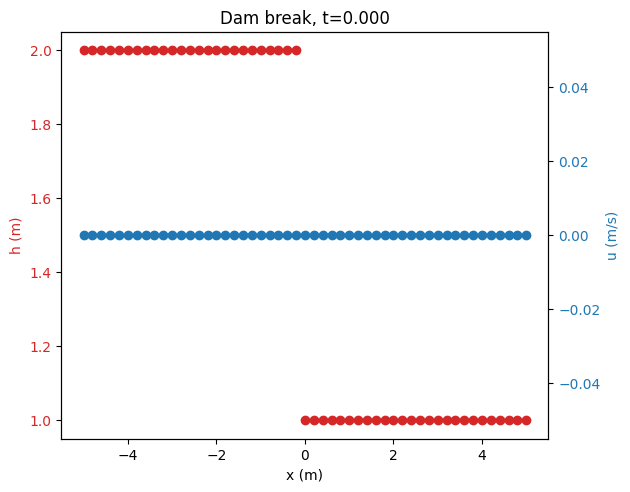

In [2]:
# now we set up a test problem, we'll do a classic "dam break" with still water at different heights in the left and right halves of the domain.
# the grid is 10 m long with water at 2m when x<0 and 1m when x>0.
dam = Grid(51)
dam.set_x0(-5.0)
dam.set_x1(5.0)
dam.generate()

# set up the inital conditions
dam.u[1,:] = 0.0
midpoint = dam.N_i // 2
dam.u[0,:midpoint] = 2.0 * 9.81
dam.u[0,midpoint:] = 1.0 * 9.81

# check what we've got.
print(dam)
dam.plot('Dam break')

##  MacCormack scheme 
Using the MacCormack scheme means we can reuse a lot of the linear advection scheme solver.  We do 
need to compute the flux term,

$$\frac\partial{\partial x}\begin{pmatrix}\phi u\\ \phi u^2+\frac{1}{2}\phi^2\end{pmatrix}$$

based on the current values of $\phi$ and $\phi u$ in each cell.  So we'll write a flux function to do this

In [3]:
def flux(u):
    # compute the flux for the shallow water equations
    F = np.zeros_like(u)
    F[0] = u[1] # phi u
    
    # we need phi u^2 and this is the same as (phi u)^2/phi!
    F[1] = u[1]**2/u[0] + 0.5 *u[0]**2
    return F

In [4]:
def maccormack(grid,dt):
    '''Perform one time step using the 2nd order MacCormack 
    predictor corrector method which is equivalent to the 
    classical Lax-Wendroff scheme.'''

    # copy u values and find the flux for the preditor
    up = grid.u.copy()
    f = flux(grid.u)

    up[:,1:] = grid.u[:,1:] - dt/grid.Delta_x()*(f[:,1:] - f[:,:-1])
    
    # Corrector
    u = grid.u.copy()
    fp = flux(up)
    u[:,1:-1] = (grid.u[:,1:-1]+up[:,1:-1])/2 -  \
        dt/(2*grid.Delta_x()) * (fp[:,2:] - fp[:,1:-1])

    return u


Integrating from 0 to 0.75 seconds:
   #        dt      time
------------------------
   1 2.015e-02    0.0201
   2 2.015e-02    0.0403
   3 2.015e-02    0.0604
   4 2.015e-02    0.0806
   5 2.015e-02     0.101
   6 2.015e-02     0.121
   7 2.015e-02     0.141
   8 2.015e-02     0.161
   9 2.015e-02     0.181
  10 2.015e-02     0.201
  20 2.015e-02     0.403
  30 2.015e-02     0.604
  38 4.463e-03      0.75
------------------------


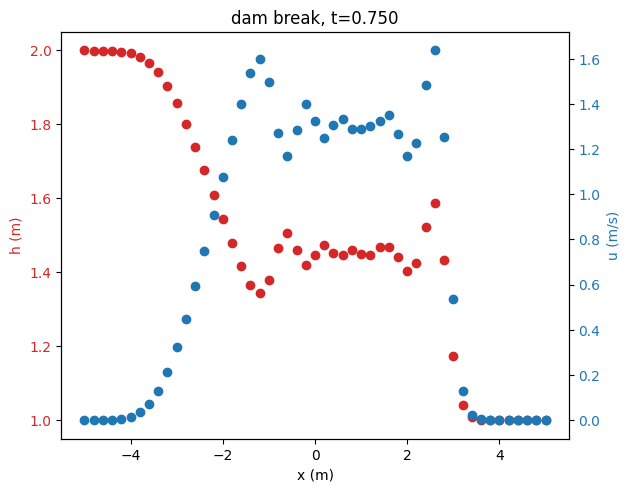

In [5]:
dam.integrate(0.75, maccormack)
dam.plot('dam break')

### Interpretation
We can see a smooth drop in heigt from 2.0 m to about 1.45 m in the left hand side of the domain, associated with a smooth increase in velocity.  This is a __centred depression__ and forms as the flow accelerates (a bit like adiabatic expansion of a pressurised gas).  There is then a "steady state" region where the water is moving at 1.8 m/s before it shocks down to stationary water with a depth of 1.0m.

The solution is rather osciliatory as we would expect from the 2nd order MacCormack scheme.  A TVD solver would sort this.

Lets try a finer grid.

Integrating from 0 to 0.75 seconds:
   #        dt      time
------------------------
   1 1.007e-03   0.00101
   2 1.007e-03   0.00201
   3 1.007e-03   0.00302
   4 1.007e-03   0.00403
   5 1.007e-03   0.00504
   6 1.007e-03   0.00604
   7 1.007e-03   0.00705
   8 1.007e-03   0.00806
   9 1.007e-03   0.00907
  10 1.007e-03    0.0101
  20 1.007e-03    0.0201
  30 1.007e-03    0.0302
  40 1.007e-03    0.0403
  50 1.007e-03    0.0504
  60 1.007e-03    0.0604
  70 1.007e-03    0.0705
  80 1.007e-03    0.0806
  90 1.007e-03    0.0907
 100 1.007e-03     0.101
 200 1.007e-03     0.201
 300 1.007e-03     0.302
 400 1.007e-03     0.403
 500 1.007e-03     0.504
 600 1.007e-03     0.604
 700 1.007e-03     0.705
 745 4.332e-04      0.75
------------------------


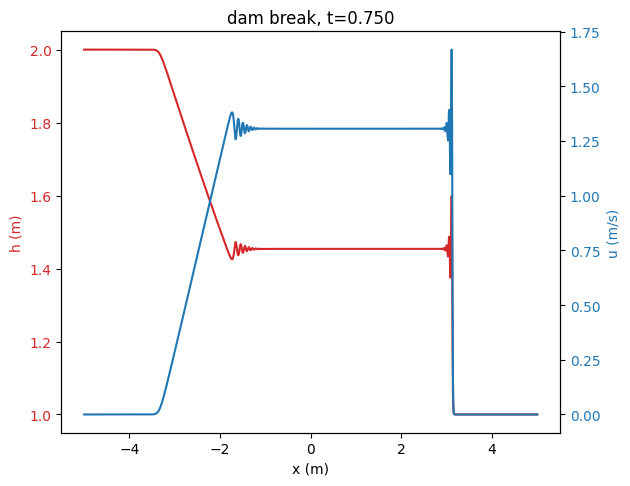

In [6]:
dam2 = Grid(1001)
dam2.set_x0(-5.0)
dam2.set_x1(5.0)
dam2.generate()

# set up the inital conditions
dam2.u[1,:] = 0.0
midpoint = dam2.N_i // 2
dam2.u[0,:midpoint] = 2.0 * 9.81
dam2.u[0,midpoint:] = 1.0 * 9.81

dam2.integrate(0.75, maccormack)
dam2.plot('dam break')


## Exercise

Use the solver to see what happens if

1. the water on the right is  2.0 meters deep and the water on the left is  1.0 meter deep. All the water is stationary.
2. the water in the middle third of the domain is  1.5 meters deeep and the rest is  1.0 meter deep. All the water is stationary.
3. all the water is 1 meter deep, but the left hand side of the domain is moving at 0.1 m/s. 
4. all the water is 1 meter deep, but the right hand side of the domain is moving at 0.1 m/s.
5. all the water is 1 meter deep, but the left hand side of the domain is moving at 0.1 m/s and the right hand side at -1.0 m/s.
6. the water on left hand side is 1.1 meters deep and the water on the right hand side is 0.1 meters deep.